# Train RetinaNet model on CMCT-MEL data set

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import sqlite3
import numpy as np
from SlideRunner.dataAccess.database import Database
from tqdm import tqdm
from pathlib import Path
import openslide
import time
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from random import randint
from data_loader import *
from lib.sampling import get_slides
from lib.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric
from lib.object_detection_helper import *
from model.RetinaNetFocalLoss import RetinaNetFocalLoss
from model.RetinaNet import RetinaNet

path = Path('databases/')

database = Database()
database.open(str(path/'MITOS_WSI_CCMCT_MEL.sqlite'))

slidelist_test_1 = ['14', '18', '3', '22', '10', '15' , '22']
slidelist_test_2 = ['1', '20', '17', '5', '2', '11' , '16']
slidelist_test_3 = ['13', '7', '19', '8', '6', '9' , '12']

slidelist_test = ['27', '30', '31', '6', '18', '20', '1', '2', '3' ,'9', '11']


## Split dataset into train/validation and test on slide level

In [6]:
getslides = """SELECT filename FROM Slides"""
all_slides = database.execute(getslides).fetchall()


Convert database into in-memory object

In [7]:
lbl_bbox, train_slides,val_slides,files = get_slides(slidelist_test=slidelist_test, database=database, negative_class=4)
            

Loading slides .. : 100%|██████████████████████| 32/32 [00:42<00:00,  1.33s/it]


In [8]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      max_rotate=90,
                      max_lighting=0.0,
                      max_zoom=1.,
                      max_warp=0.0,
                      p_affine=0.5,
                      p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

/tmp/ipykernel_28443/2371571183.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  img2bbox = dict(zip(files, np.array(lbl_bbox)))


In [9]:
bs = 16
train_images = 5000
val_images = 5000
size=256

train_files = list(np.random.choice([files[x] for x in train_slides], train_images))
valid_files = list(np.random.choice([files[x] for x in val_slides], val_images))


train =  ObjectItemListSlide(train_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
valid = ObjectItemListSlide(valid_files, path=path)
item_list = ItemLists(path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate_min).normalize()

/home/rajiv/anaconda3/envs/py35/lib/python3.9/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


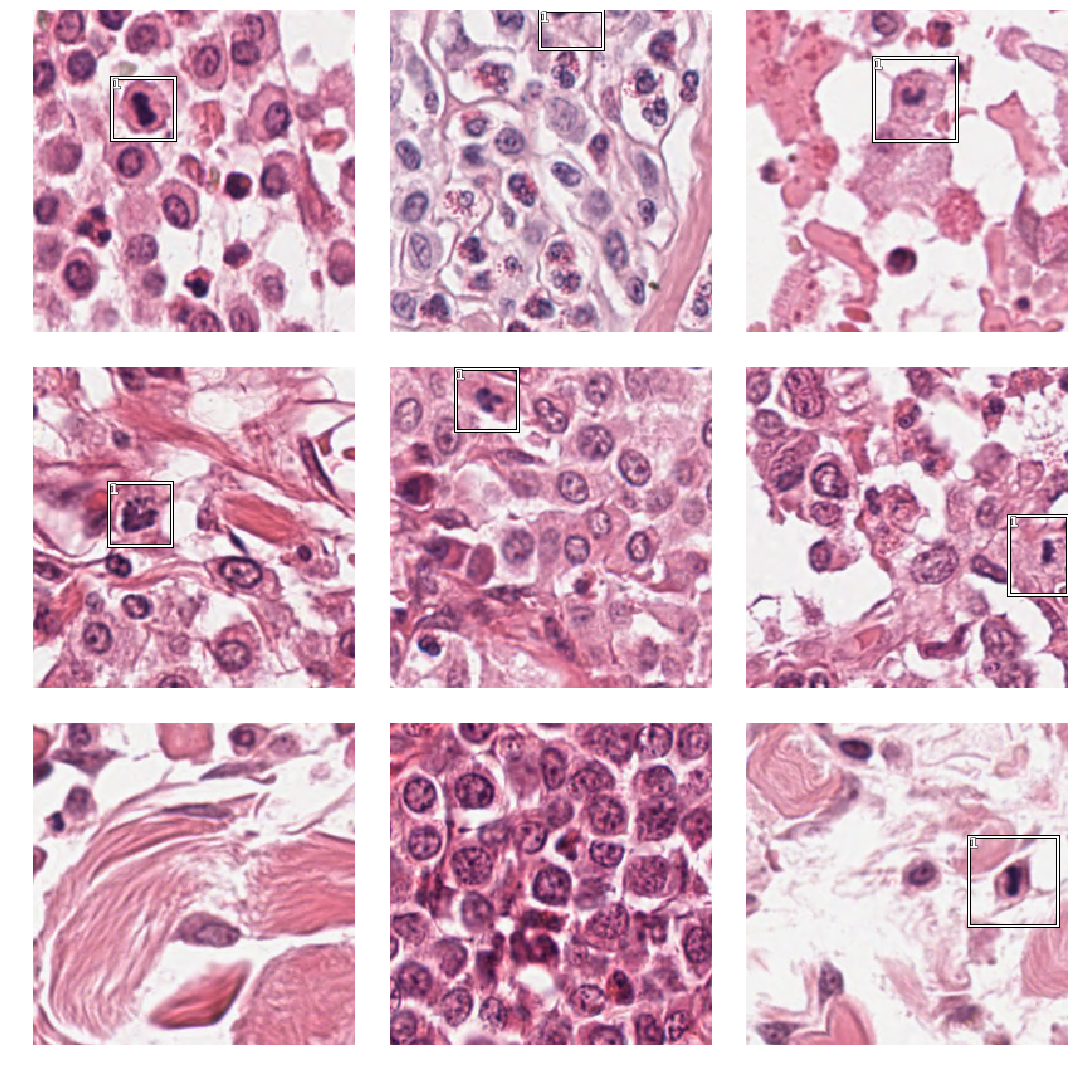

In [6]:
data.show_batch(rows=3, ds_type=DatasetType.Train, figsize=(15,15))

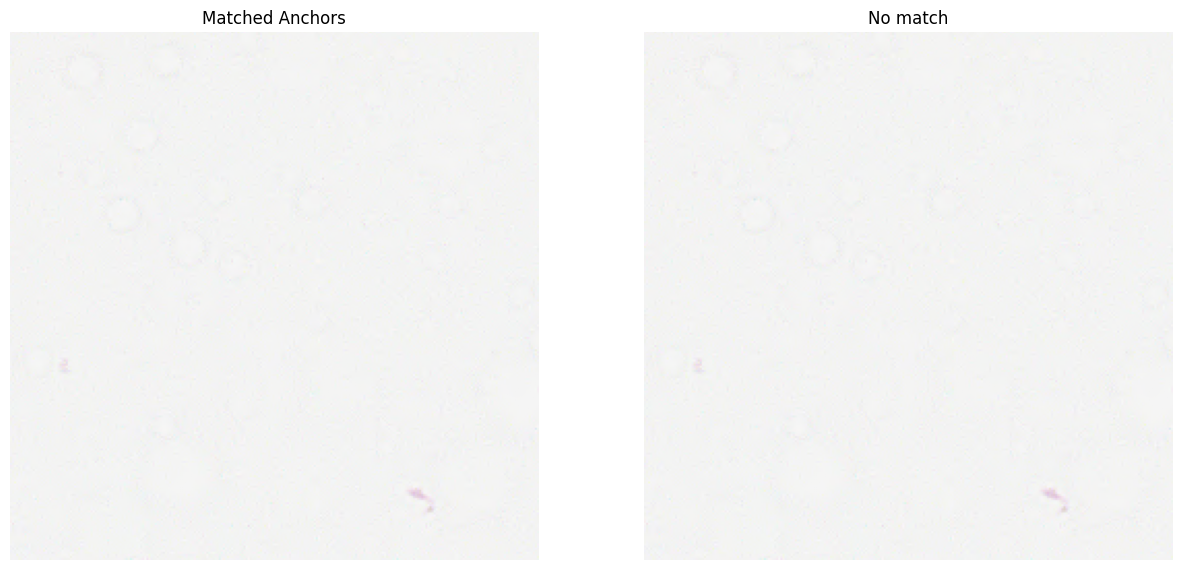

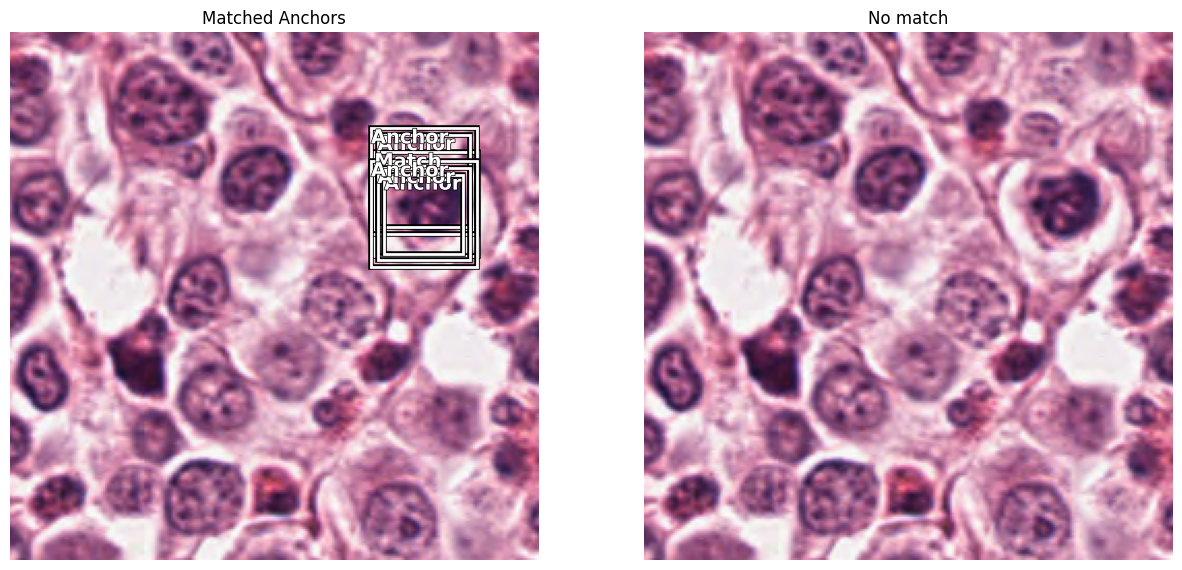

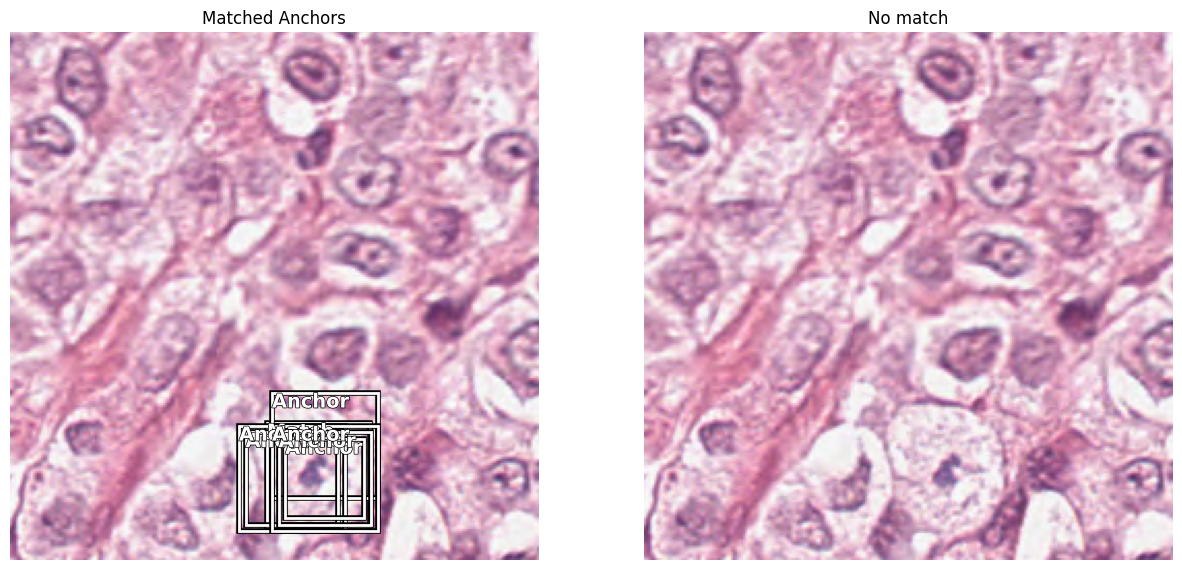

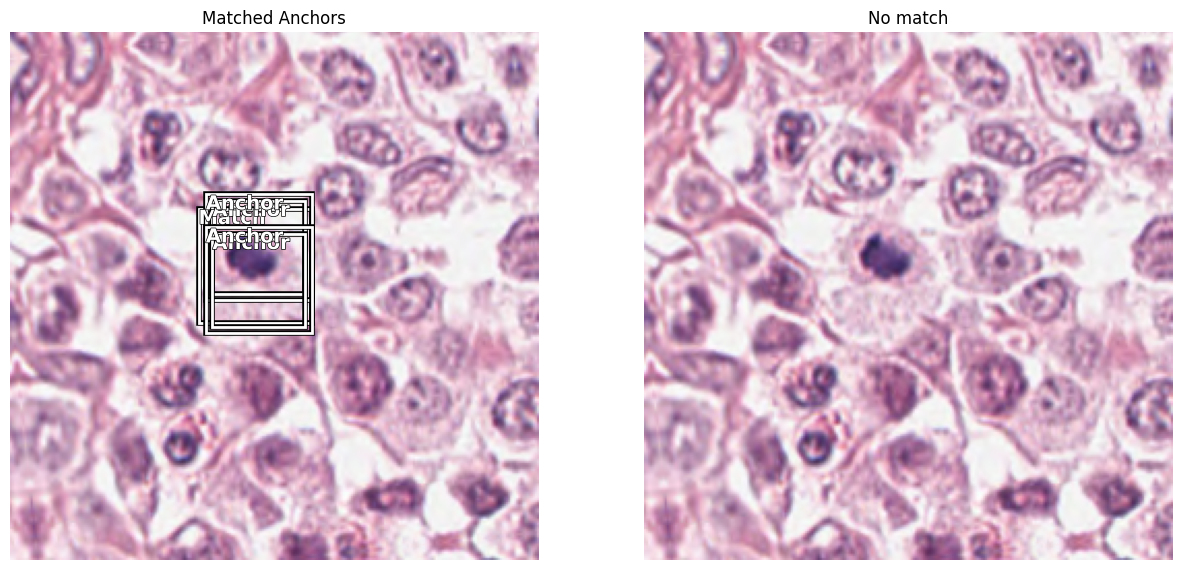

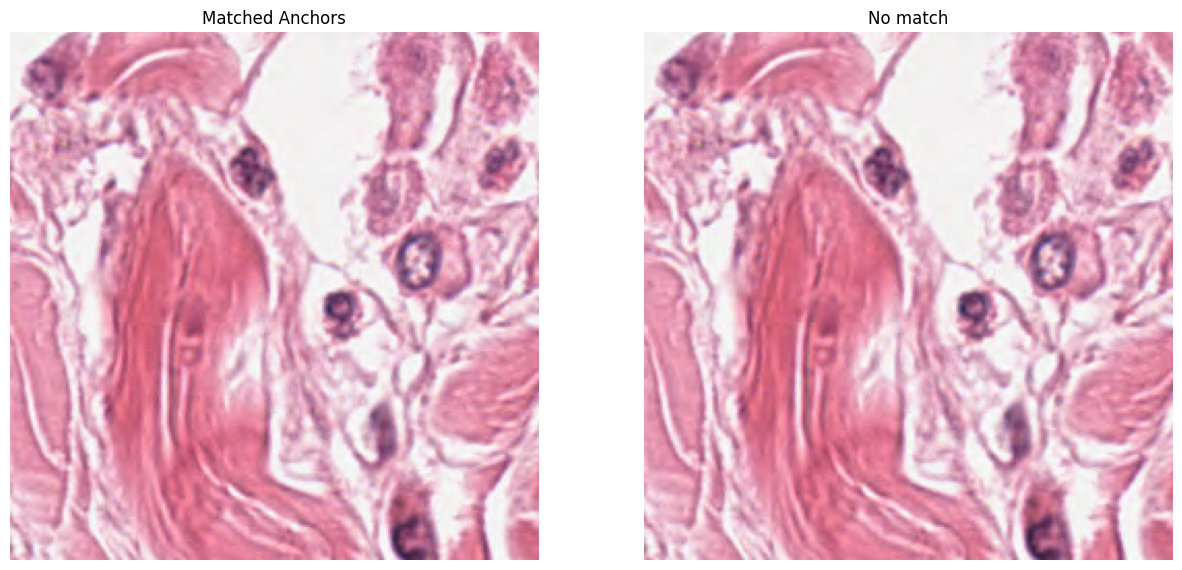

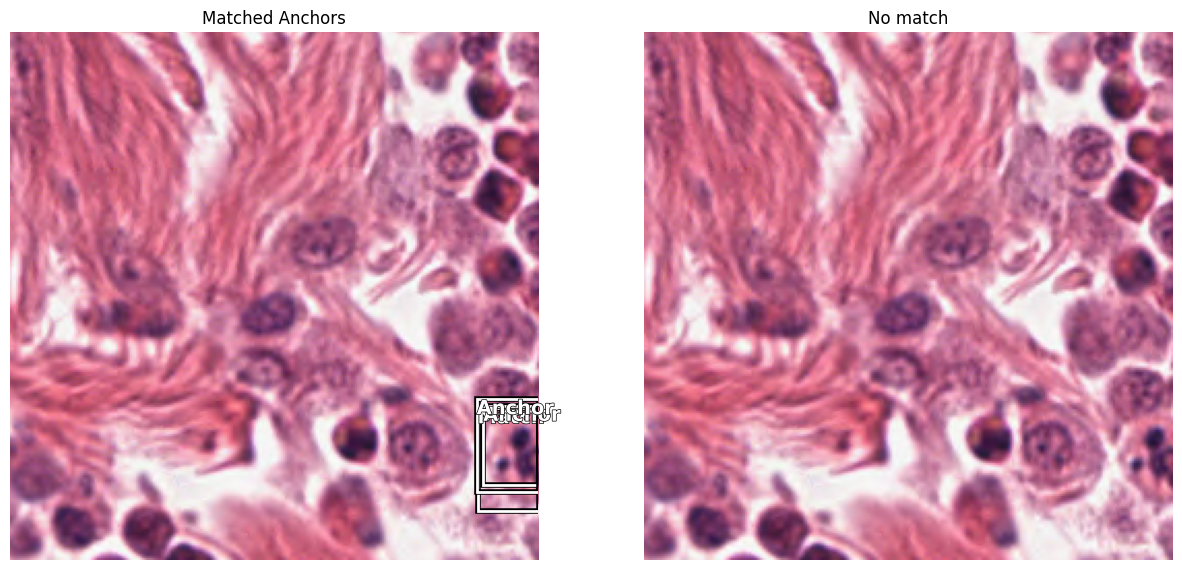

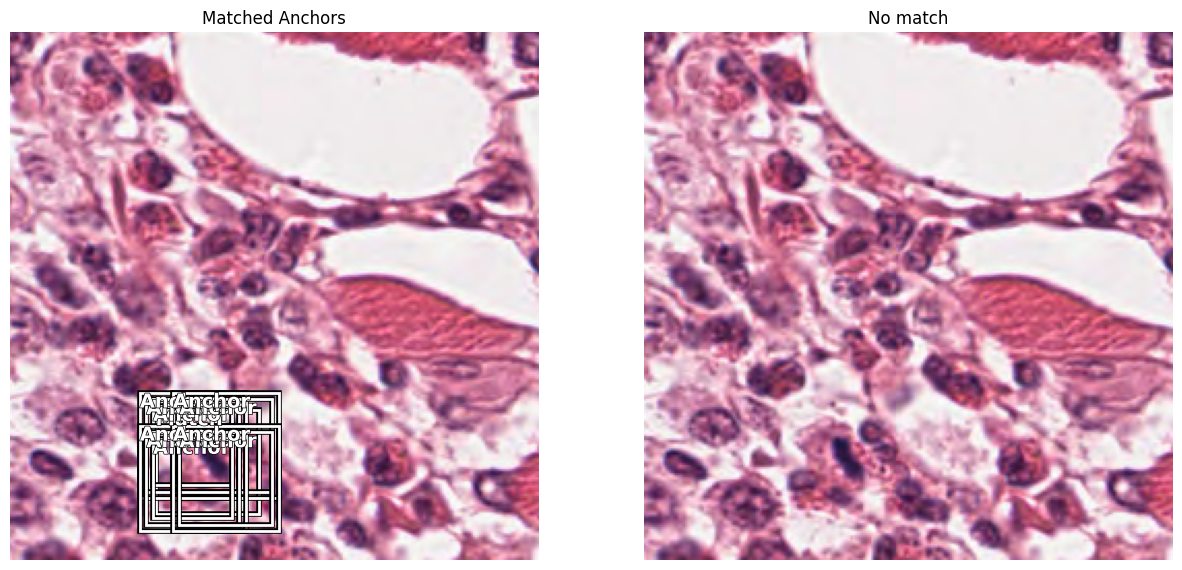

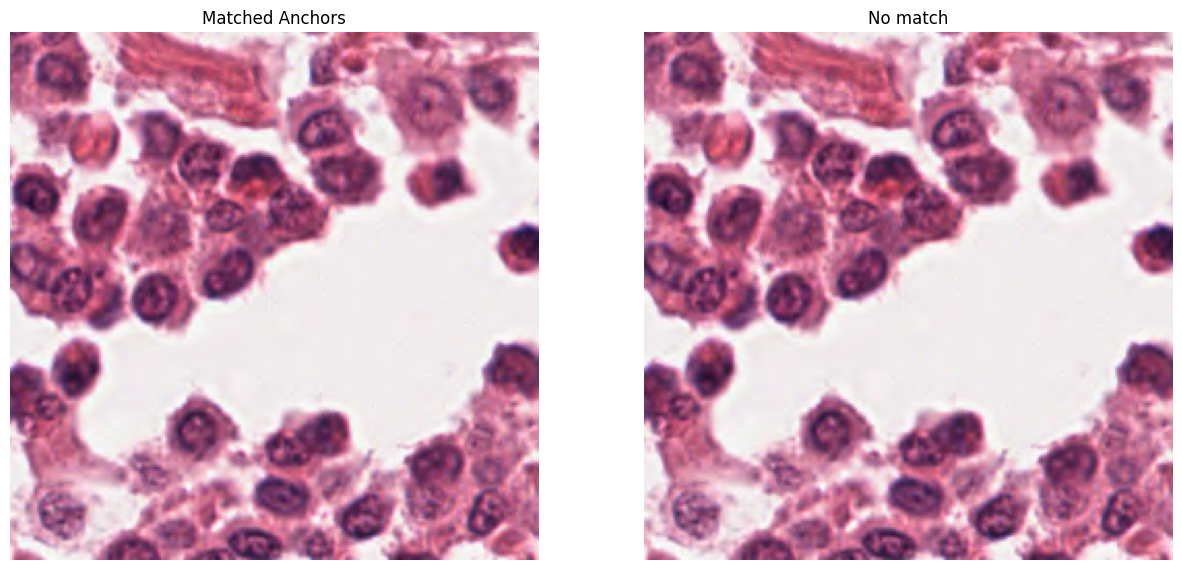

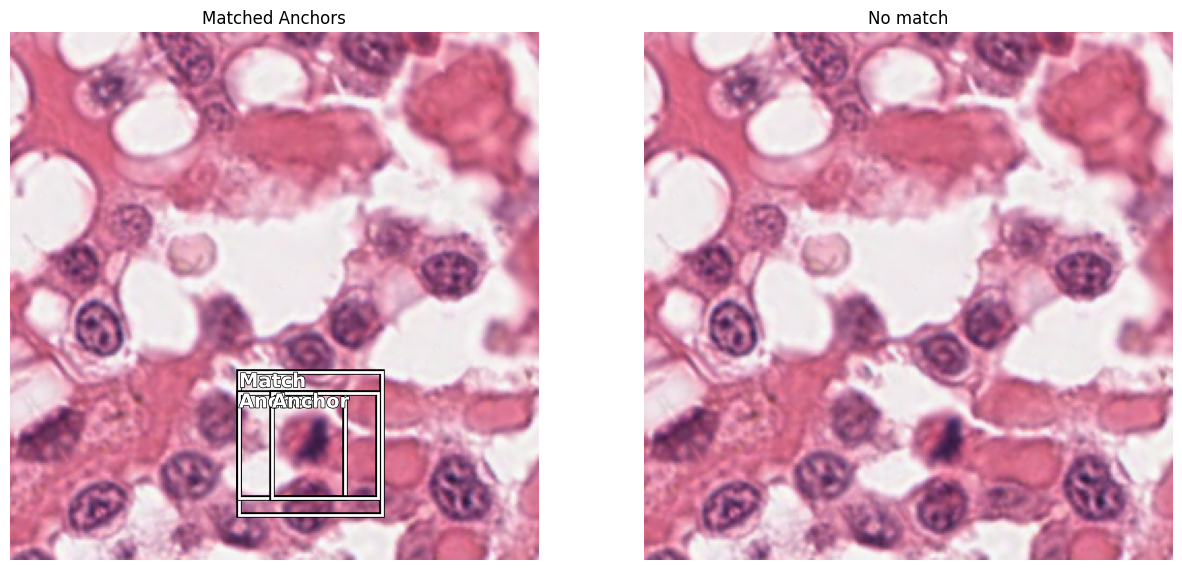

In [10]:
anchors = create_anchors(sizes=[(16,16)], ratios=[1], scales=[0.6, 0.7,0.8])
not_found = show_anchors_on_images(data, anchors)

In [12]:
crit = RetinaNetFocalLoss(anchors)
encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=3, sizes=[16], chs=128, final_bias=-4., n_conv=3)



In [13]:
voc = PascalVOCMetric(anchors, size, [str(i-1) for i in data.train_ds.y.classes[1:]])
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics, ShowGraph], #BBMetrics, ShowGraph
                metrics=[voc]
               )

In [14]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)


Run learning rate finder

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


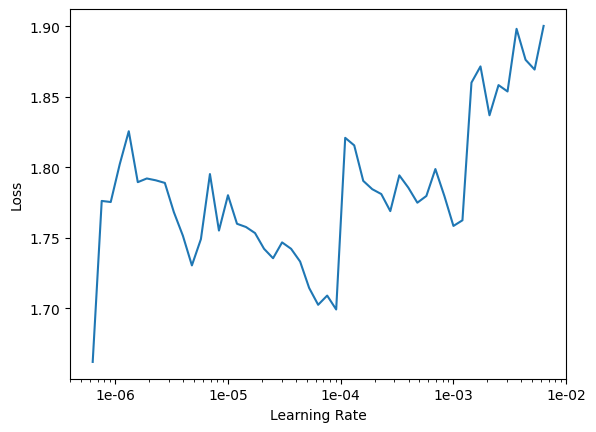

In [11]:
learn.lr_find()
learn.recorder.plot()

GT: 100%|████████████████████████████████████████| 1379/1379 [00:00<00:00, 2233.31it/s]


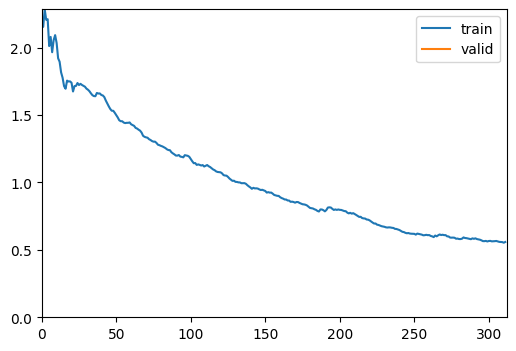

In [12]:
learn.fit_one_cycle(1, 1e-4)

GT: 100%|████████████████████████████████████████| 1713/1713 [00:00<00:00, 3018.17it/s]


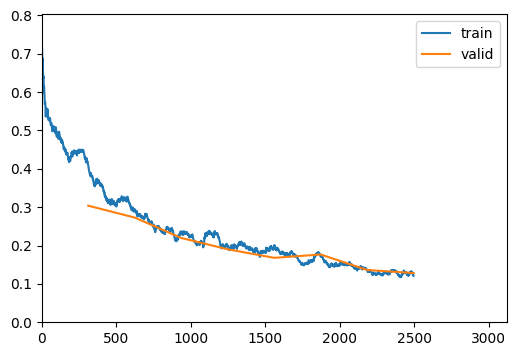

GT: 100%|████████████████████████████████████████| 1867/1867 [00:00<00:00, 3541.33it/s]


KeyboardInterrupt: 

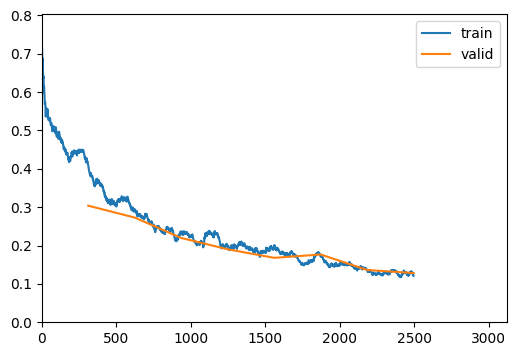

In [14]:
lr=1e-4
learn.fit_one_cycle(10, lr)#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='AP-0', name='model')])

In [ ]:
learn.unfreeze()
lr=1e-4

for k in range(3):
    learn.fit_one_cycle(10, lr)

GT: 100%|██████████| 1807/1807 [00:00<00:00, 4661.78it/s]


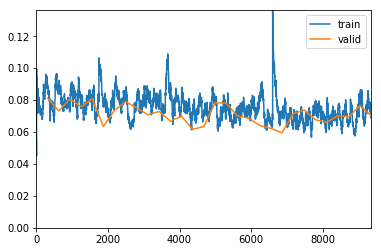

Better model found at epoch 0 with pascal_voc_metric value: 0.8195081488515118.


GT: 100%|██████████| 1852/1852 [00:00<00:00, 5905.85it/s]


Better model found at epoch 1 with pascal_voc_metric value: 0.8409151542991442.


GT: 100%|██████████| 1814/1814 [00:00<00:00, 5096.22it/s]


Better model found at epoch 2 with pascal_voc_metric value: 0.8688385460724448.


GT: 100%|██████████| 1786/1786 [00:00<00:00, 6270.90it/s]


Better model found at epoch 7 with pascal_voc_metric value: 0.8704686091849666.


GT: 100%|██████████| 1756/1756 [00:00<00:00, 6235.17it/s]


Better model found at epoch 13 with pascal_voc_metric value: 0.8820787369987576.


GT: 100%|██████████| 1836/1836 [00:00<00:00, 5209.60it/s]


Better model found at epoch 14 with pascal_voc_metric value: 0.8898606655356095.


GT: 100%|██████████| 1810/1810 [00:00<00:00, 6244.58it/s]


Better model found at epoch 23 with pascal_voc_metric value: 0.9023166050966178.


GT: 100%|██████████| 1822/1822 [00:00<00:00, 5346.62it/s]


In [15]:
lr=1e-4

learn.fit(30, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

GT: 100%|██████████| 1868/1868 [00:00<00:00, 5710.06it/s]


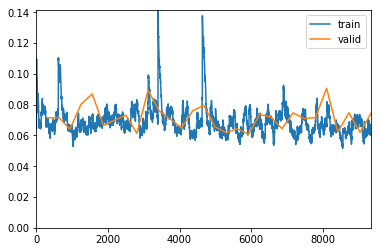

Better model found at epoch 0 with pascal_voc_metric value: 0.7932943225808379.


GT: 100%|██████████| 1828/1828 [00:00<00:00, 5838.18it/s]


Better model found at epoch 1 with pascal_voc_metric value: 0.843912491630408.


GT: 100%|██████████| 1803/1803 [00:00<00:00, 6063.26it/s]


Better model found at epoch 2 with pascal_voc_metric value: 0.8523170965180356.


GT: 100%|██████████| 1808/1808 [00:00<00:00, 6065.58it/s]


Better model found at epoch 6 with pascal_voc_metric value: 0.860574431391195.


GT: 100%|██████████| 1799/1799 [00:00<00:00, 5997.73it/s]


Better model found at epoch 8 with pascal_voc_metric value: 0.8633311328809633.


GT: 100%|██████████| 1838/1838 [00:00<00:00, 6161.06it/s]


Better model found at epoch 9 with pascal_voc_metric value: 0.8725421957200346.


GT: 100%|██████████| 1832/1832 [00:00<00:00, 5137.97it/s]


Better model found at epoch 17 with pascal_voc_metric value: 0.8862737713586886.


GT: 100%|██████████| 1792/1792 [00:00<00:00, 6257.49it/s]


Better model found at epoch 29 with pascal_voc_metric value: 0.8863836756159229.


In [16]:
learn.unfreeze()
lr=1e-4

learn.fit(30, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='pascal_voc_metric', name='model')])

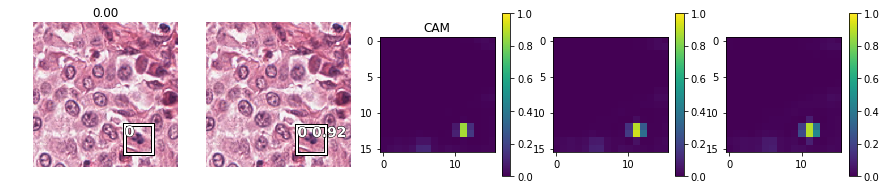

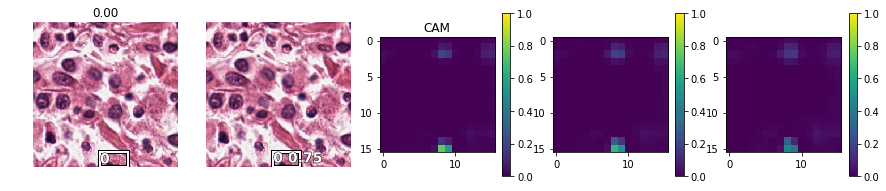

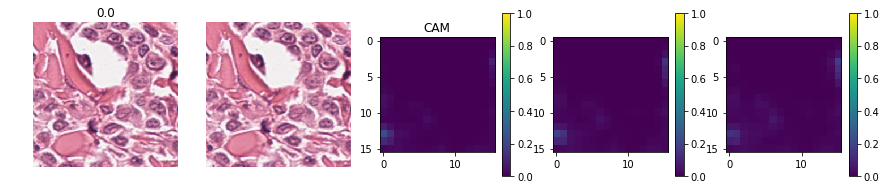

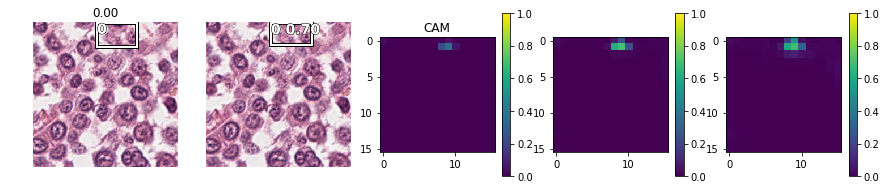

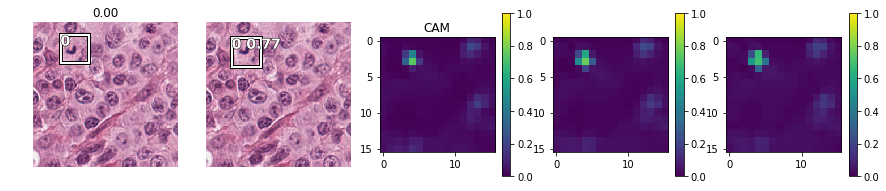

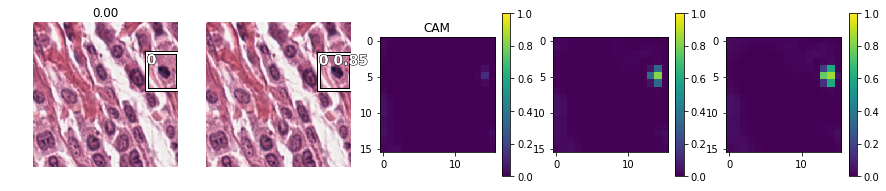

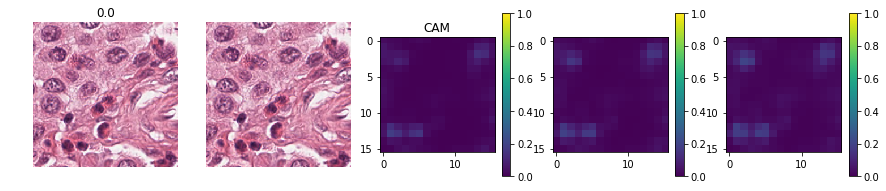

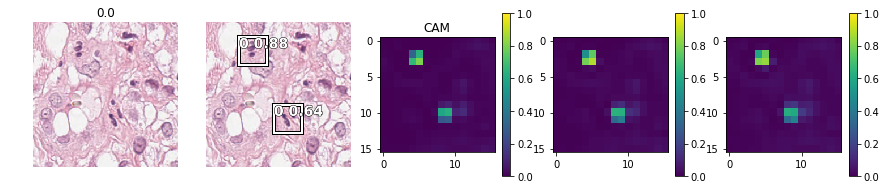

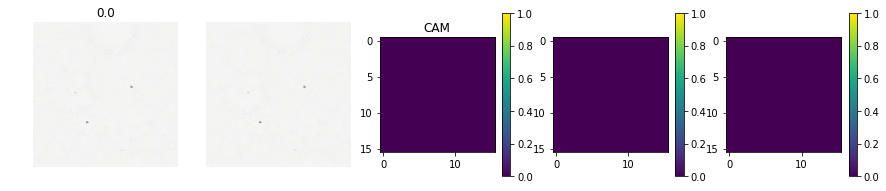

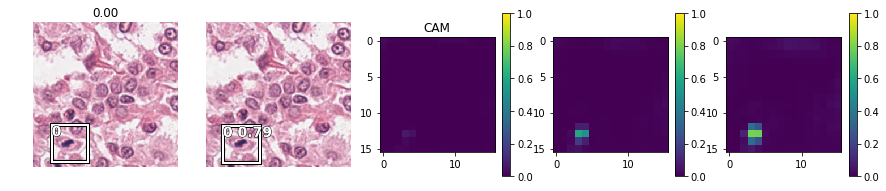

In [17]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2, image_count=10)

In [15]:
learn.export("../RetinaNet-MEL-export.pth")